# Comparing McKinley Park's PurpleAir (PA) sensors to EPA AirNow's (AN) sensors using accuracy correction formulae

In this notebook we recreate the analysis from the `compare_airnow_and_purpleair` notebook but we take into account various correction formulae for the PA sensors found in the literature. Formally, we are interested in testing the hypothesis that the McKinley PurpleAir readings are significantly different than the EPA's AirNow readings.

## TODO Literature review

#### TODO look into AQandU and LRAPA corrections, are these woodsmoke-specific corrections?
#### TODO why does woodsmoke have to be considered differently?

In this section we briefly review some of the literature that compares the PM2.5 measurements of the PurpleAir sensors to that of other sensors.

###  Basic notions

### Comparisons and correction formulae

### References

[1] https://cfpub.epa.gov/si/si_public_record_Report.cfm?dirEntryId=350075&Lab=CEMM

[2] https://www.sciencedirect.com/science/article/abs/pii/S135223102100251X

[3] https://api.purpleair.com/

[4] https://map.purpleair.com

[5] http://lar.wsu.edu/nw-airquest/docs/20200610_meeting/NWAQ_20200611_1030_Hadley.pdf

## Analysis

### Imports and utility

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.precision = 1

PATH = '../data/'
SEASONS = ['summer', 'autumn']
FILE_STUBS = {'an': '_2021_airnow',
              'pa': '_2021_pa_'}
CHANNELS = {'a': 'parent',
            'b': 'child'}

# features of interest (and how we'll rename them)
COLUMNS = {'pa': {'season': 'season',
                  'sensor': 'sensor',
                  'created_at': 'date',
                  'pm2.5_(cf=1)_ug/m3': 'pm25_cf_1',
                  'pm2.5_(cf=atm)_ug/m3': 'pm25_cf_atm',
                  'temperature_f': 'temperature_f',
                  'humidity_%': 'humidity_%'},
           'an': {'season': 'season',
                  'latitude': 'latitude',
                  'longitude': 'longitude',
                  'datetime': 'date',
                  'concentration': 'pm25'}}

### Load data into PA and AN DataFrames

Each DataFrame contains data for PM2.5, humidity, etc. for both seasons. Following [1], the PurpleAir data is averaged over the parent and child data (A and B channels) when possible. From the PA sensors, we keep only those located in McKinley Park, which is our region of interest.

#### TODO what happens when the A and B channels differ significantly?

In [3]:
def load_data(dataset):
    # TODO documentation
    
    df = pd.DataFrame()
    
    if dataset == 'pa':
        for season in SEASONS:
            for channel in CHANNELS.keys():
                filename = f'{PATH}{season}{FILE_STUBS[dataset]}{CHANNELS[channel]}.csv'
                df_season_channel = pd.read_csv(filename)
                df_season_channel['season'] = season
                df = df.append(df_season_channel)
        
    elif dataset == 'an':
        for season in SEASONS:
            filename = f'{PATH}{season}{FILE_STUBS[dataset]}.csv'
            df_season = pd.read_csv(filename)
            # keep only PM2.5 data
            df_season = df_season[df_season['Parameter'] == 'PM2.5']
            df_season['season'] = season
            df = df.append(df_season)
        
    else:
        raise ValueError(f'Could not find dataset {dataset}!')
        
    # clean up headers, prune extraneous data
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df = df[list(COLUMNS[dataset].keys())]
    df.rename(columns = COLUMNS[dataset], inplace = True)
    
    # convert date format to 'mm-yy HH:mm' (24hour time)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime('%m/%d %H:%M')
    
    # for PurpleAir data, average the PM2.5 readings between the a and b channels
    # and keep the humidity and temperature readings, which are only present in the a channel
    
    return df

For the PurpleAir data, we'll average the PM2.5 readings between the a and b channels (throwing away any points for which one is missing). We'll use the PM2.5 CF=1 data, and moreover, keep the temperature and humidity data, which is only present on the a channel.

The a channel and b channel have sensor IDs that differ by 1.

#### TODO make sure to understand the merge behavior (here and below where we merge an and pa)

In [4]:
df_pa = load_data('pa')

SENSOR_PAIRS = {'36th and Paulina': (96035, 96036),
                '38th & Winchester': (96395, 96396),
                '39th and Damen (NLEI)': (94975, 94976)}

df_pa_ab_avg = pd.DataFrame()
for monitor in SENSOR_PAIRS.keys():
    df_a = df_pa[df_pa['sensor'] == SENSOR_PAIRS[monitor][0]]
    df_b = df_pa[df_pa['sensor'] == SENSOR_PAIRS[monitor][1]][['date', 'pm25_cf_1']]
    
    df_merged = df_a.merge(df_b, left_on = 'date', right_on = 'date')
    df_merged['pm25'] = (df_merged['pm25_cf_1_x'] + df_merged['pm25_cf_1_y']) / 2
    df_merged['sensor'] = monitor
    df_merged = df_merged[['season', 'sensor', 'date', 'pm25', 'temperature_f', 'humidity_%']]
    
    df_pa_ab_avg = df_pa_ab_avg.append(df_merged)

df_pa_ab_avg.head()

,season,sensor,date,pm25,temperature_f,humidity_%
0,summer,36th and Paulina,07/25 00:01,15.3,87.0,65.0
1,summer,36th and Paulina,07/25 00:03,13.7,87.0,66.0
2,summer,36th and Paulina,07/25 00:05,14.8,86.0,67.0
3,summer,36th and Paulina,07/25 00:07,17.7,87.0,67.0
4,summer,36th and Paulina,07/25 00:09,18.4,87.0,66.0


There's not as much to do for the AirNow data. We'll just replace the latitude/longitude with a human-readable location.

In [5]:
df_an = load_data('an')
sensorCoords_an = df_an[['latitude', 'longitude']].drop_duplicates().sort_values(by='latitude').reset_index()
locations_an = {0: 'Alsip',
                1: 'Springfield Pump',
                2: 'Cicero',
                3: 'Com Ed',
                4: 'Des Plaines'}               
sensorCoords_an['sensor'] = locations_an.values()
df_an = df_an.merge(sensorCoords_an[['latitude', 'longitude', 'sensor']],
                    how='outer', on=['latitude', 'longitude'])
df_an = df_an.drop(['latitude', 'longitude'], axis = 1)
df_an.head()

,season,date,pm25,sensor
0,summer,07/04 02:00,10.5,Des Plaines
1,summer,07/04 03:00,12.2,Des Plaines
2,summer,07/04 04:00,16.1,Des Plaines
3,summer,07/04 05:00,18.1,Des Plaines
4,summer,07/04 06:00,16.6,Des Plaines


### Take daily averages

The PurpleAir data is recorded in 2 minute increments while the AirNow data is recorded hourly. We average the data to obtain daily values for the purposes of comparison. In particular, we average together all the PurpleAir McKinley Park sensors and average together all the AirNow sensors. As before, we carry the temperature and humidity measurements along for the ride.

In [14]:
df_pa_ab_avg['day'] = df_pa_ab_avg['date'].str.split(' ').apply(lambda x: x[0])
daily_pa = df_pa_ab_avg.groupby(['season', 'day'], as_index = False)
df_pa_daily = daily_pa[['pm25', 'temperature_f', 'humidity_%']].mean()
df_pa_daily.head()

,season,day,pm25,temperature_f,humidity_%
0,autumn,10/05,10.7,70.6,69.2
1,autumn,10/06,27.3,70.6,71.5
2,autumn,10/07,23.1,73.2,72.2
3,autumn,10/08,21.4,74.6,66.2
4,autumn,10/09,21.1,76.1,61.8


In [16]:
df_an['day'] = df_an['date'].str.split(' ').apply(lambda x: x[0])
daily_an = df_an.groupby(['season', 'day'], as_index = False)
df_an_daily = daily_an[['pm25']].mean()
df_an_daily.head()

,season,day,pm25
0,autumn,10/05,6.5
1,autumn,10/06,11.9
2,autumn,10/07,10.7
3,autumn,10/08,7.8
4,autumn,10/09,10.9


For convenience of comparison, we combine both DataFrames.

In [62]:
df_daily = df_pa_daily.merge(df_an_daily, left_on = 'day', right_on = 'day').rename(columns = {'pm25_x': 'pm25_pa', 'pm25_y': 'pm25_an', 'season_x': 'season'})
del df_daily['season_y']
df_daily.head()

,season,day,pm25_pa,temperature_f,humidity_%,pm25_an
0,autumn,10/05,10.7,70.6,69.2,6.5
1,autumn,10/06,27.3,70.6,71.5,11.9
2,autumn,10/07,23.1,73.2,72.2,10.7
3,autumn,10/08,21.4,74.6,66.2,7.8
4,autumn,10/09,21.1,76.1,61.8,10.9


### Short aside on relative humidity

Relative humidity can have a significant impact on particulate matter sensors, as high relative humidity causes particles to swell in size. Some of the accuracy correction formulae involve relative humidity, so we might ask whether the humidity accounts for some of the variation between the two datasets. The scatterplot below is a bit muddled, so it's hard to say. There is higher variation in the two datasets during the summer, so the orange peak does not seem to be indicating any sort of trend.

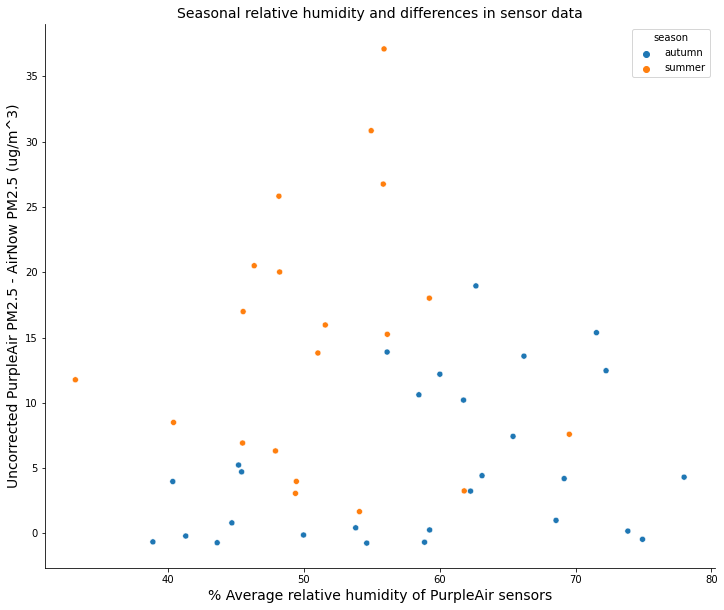

In [103]:
fig, ax = plt.subplots(figsize=(12,10))
daily_diff = df_daily['pm25_pa'] - df_daily['pm25_an']

sns.scatterplot(data = df_daily, x = df_daily['humidity_%'], y = daily_diff, hue = 'season', ax = ax);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('% Average relative humidity of PurpleAir sensors', fontsize=14)
ax.set_ylabel('Uncorrected PurpleAir PM2.5 - AirNow PM2.5 (ug/m^3)', fontsize=14)
ax.set_title('Seasonal relative humidity and differences in sensor data', fontsize=14);

### US EPA accuracy correction [1]

We now use the EPA's accuracy correction formula from [1], which takes into account the relative humidity measured in the PurpleAir sensor. Note that this correction formula underestimates concentrations when the PM2.5 is greater than 250 ug/m^3. These are levels that we don't tend to see in Chicago, thankfully.

In [76]:
def correction_epa(pm25, rh):
    return 0.52 * pm25 - 0.085 * rh + 5.71

# apply the correction row-wise
df_daily['pm25_pa_corr_epa'] = df_daily.apply(lambda row: correction_epa(row['pm25_pa'], row['humidity_%']), axis = 1)
df_daily.head()

,season,day,pm25_pa,temperature_f,humidity_%,pm25_an,pm25_pa_corr_epa
0,autumn,10/05,10.7,70.6,69.2,6.5,5.4
1,autumn,10/06,27.3,70.6,71.5,11.9,13.8
2,autumn,10/07,23.1,73.2,72.2,10.7,11.6
3,autumn,10/08,21.4,74.6,66.2,7.8,11.2
4,autumn,10/09,21.1,76.1,61.8,10.9,11.4


### Correlation between PA and AN

Directly comparing the two datasets, we see that while they are tightly correlated, the uncorrected PurpleAir sensors record significantly higher PM2.5 readings. Under the null hypothesis (that is, there is no significant difference between the PurpleAir and AirNow readings), this would be consistent with the claims from [1], [2], etc. that the PurpleAir readings tend to be almost twice as high as those from FRMs/FEMs. Applying the EPA correction brings the PurpleAir data much closer in line with the AirNow data.

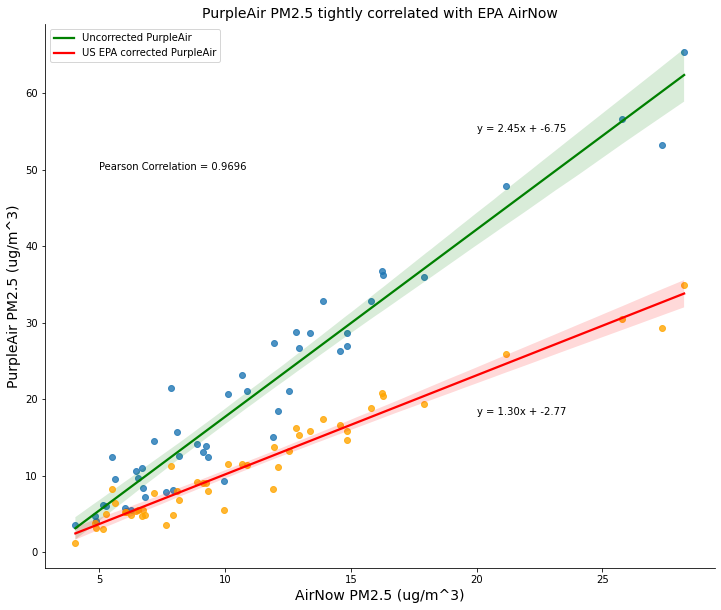

In [102]:
fig, ax = plt.subplots(figsize = (12, 10))

ax = sns.regplot(x = 'pm25_an', y = 'pm25_pa', data = df_daily, ax = ax, line_kws = {'color': 'green'})
ax = sns.regplot(x = 'pm25_an', y = 'pm25_pa_corr_epa', data = df_daily, ax = ax, color = 'orange', line_kws = {'color': 'red'})
ax.text(x = 5, y = 50, s = f'Pearson Correlation = {df_daily["pm25_pa"].corr(df_daily["pm25_an"]):.4f}')

# get the equations for the linear regression lines
text_positions = [(20, 55), (20, 18)]
for i in range(2):
    line_xs = ax.get_lines()[i].get_xdata()
    line_ys = ax.get_lines()[i].get_ydata()
    slope = (line_ys[1] - line_ys[0]) / (line_xs[1] - line_xs[0])
    y_intercept = line_ys[0] - slope * line_xs[0]
    ax.text(x = text_positions[i][0], y = text_positions[i][1], s= f'y = {slope:.2f}x + {y_intercept:.2f}')

plt.legend(labels = ['Uncorrected PurpleAir', 'US EPA corrected PurpleAir'])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('AirNow PM2.5 (ug/m^3)', fontsize = 14)
ax.set_ylabel('PurpleAir PM2.5 (ug/m^3)', fontsize = 14)
ax.set_title('PurpleAir PM2.5 tightly correlated with EPA AirNow', fontsize = 14)
plt.savefig('../figures/acc_corr_mckinley_epa_correlation.png', bbox_inches='tight');

### Seasonal distribution of PM2.5 readings

The following plots show the seasonal distributions of the PM2.5 readings, both uncorrected and corrected. Evidently there is higher PM2.5 as well as higher variance in PM2.5 during the summer in both data sets. Again, we see that the US EPA correction factor brings the PurpleAir data closer in line with the AirNow data, especially when split seasonally.

In [96]:
df_daily_melt = df_daily[['season', 'day', 'pm25_pa', 'pm25_pa_corr_epa', 'pm25_an']].melt(id_vars = ['day', 'season'])
df_daily_melt = df_daily_melt.rename(columns = {'variable': 'type', 'value': 'pm25'})

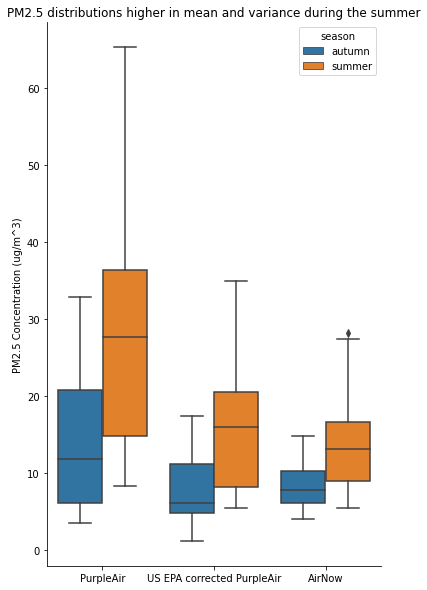

In [106]:
fig, ax = plt.subplots(figsize = (6, 10))
sns.boxplot(data = df_daily_melt, x = 'type', y = 'pm25', hue='season', ax=ax)

ax.set_xticklabels(['PurpleAir', 'US EPA corrected PurpleAir', 'AirNow'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(None)
ax.set_ylabel('PM2.5 Concentration (ug/m^3)')
ax.set_title('PM2.5 distributions higher in mean and variance during the summer')
plt.savefig('../figures/acc_corr_mckinley_epa_pm25_seasonal_dist.png');

### Daily differences

### Daily AQI categories